In [71]:
# importing required libraries
import numpy as np
import pandas as pd
import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout # importing dense layer
from keras.models import Sequential #importing Sequential layer
from keras.layers import Input
from keras.models import Model
# representation of model layers
from keras.utils.vis_utils import plot_model

## Reading Data

In [72]:
feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count", 
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]

train='./nslkdd/KDDTrain+.txt'
train_data=pd.read_csv(train,names=feature)
data= train_data
# remove attribute 'difficulty_level'
data.drop(['difficulty'],axis=1,inplace=True)
def change_label(df):
        df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
        df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
        df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
        df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

change_label(data)
label = pd.DataFrame(data.label)

### Protocol

In [73]:
# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
    for i in col:
        arr = df[i]
        arr = np.array(arr)
        df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
    return df

numeric_col = data.select_dtypes(include='number').columns
data = standardization(data,numeric_col)
le2 = preprocessing.LabelEncoder()
enc_label = label.apply(le2.fit_transform)
data['intrusion'] = enc_label
print(data.shape)
data.drop(labels= ['label'], axis=1, inplace=True)
print(data.shape)
data = pd.get_dummies(data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  
print(data.shape)
y_data= data['intrusion']
X_data= data.drop(labels=['intrusion'], axis=1)

print('X_train has shape:',X_data.shape,'\ny_train has shape:',y_data.shape)

from sklearn.preprocessing import LabelBinarizer
y_data = LabelBinarizer().fit_transform(y_data)

X_data=np.array(X_data)
y_data=np.array(y_data)


(125973, 43)
(125973, 42)
(125973, 123)
X_train has shape: (125973, 122) 
y_train has shape: (125973,)


In [74]:
# X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.25, random_state=42)
# print(X_train.shape,'\n',X_test.shape)

X_train, X_test, y_train, y_test = train_test_split(X_data,y_data, test_size=0.25, random_state=0)
print(X_train.shape,'\n',X_test.shape)

(94479, 122) 
 (31494, 122)


In [75]:
from abc import ABCMeta, abstractmethod

import numpy as np
from scipy.stats import truncnorm
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin



def batch_generator(batch_size, data, labels=None):
    """
    Generates batches of samples
    :param data: array-like, shape = (n_samples, n_features)
    :param labels: array-like, shape = (n_samples, )
    :return:
    """
    n_batches = int(np.ceil(len(data) / float(batch_size)))
    idx = np.random.permutation(len(data))
    data_shuffled = data[idx]
    if labels is not None:
        labels_shuffled = labels[idx]
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        if labels is not None:
            yield data_shuffled[start:end, :], labels_shuffled[start:end]
        else:
            yield data_shuffled[start:end, :]


def to_categorical(labels, num_classes):
    """
    Converts labels as single integer to row vectors. For instance, given a three class problem, labels would be
    mapped as label_1: [1 0 0], label_2: [0 1 0], label_3: [0, 0, 1] where labels can be either int or string.
    :param labels: array-like, shape = (n_samples, )
    :return:
    """
    new_labels = np.zeros([len(labels), num_classes])
    label_to_idx_map, idx_to_label_map = dict(), dict()
    idx = 0
    for i, label in enumerate(labels):
        if label not in label_to_idx_map:
            label_to_idx_map[label] = idx
            idx_to_label_map[idx] = label
            idx += 1
        new_labels[i][label_to_idx_map[label]] = 1
    return new_labels, label_to_idx_map, idx_to_label_map


class ActivationFunction(object):
    """
    Class for abstract activation function.
    """
    __metaclass__ = ABCMeta

    @abstractmethod
    def function(self, x):
        return

    @abstractmethod
    def prime(self, x):
        return


class SigmoidActivationFunction(ActivationFunction):
    @classmethod
    def function(cls, x):
        """
        Sigmoid function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return 1 / (1.0 + np.exp(-x))

    @classmethod
    def prime(cls, x):
        """
        Compute sigmoid first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return x * (1 - x)


class ReLUActivationFunction(ActivationFunction):
    @classmethod
    def function(cls, x):
        """
        Rectified linear function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return np.maximum(np.zeros(x.shape), x)

    @classmethod
    def prime(cls, x):
        """
        Rectified linear first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return (x > 0).astype(int)


class TanhActivationFunction(ActivationFunction):
    @classmethod
    def function(cls, x):
        """
        Hyperbolic tangent function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return np.tanh(x)

    @classmethod
    def prime(cls, x):
        """
        Hyperbolic tangent first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return 1 - x * x


class BaseModel(object):
    def save(self, save_path):
        import pickle

        with open(save_path, 'wb') as fp:
            pickle.dump(self, fp)

    @classmethod
    def load(cls, load_path):
        import pickle

        with open(load_path, 'rb') as fp:
            return pickle.load(fp)


class BinaryRBM(BaseEstimator, TransformerMixin, BaseModel):
    """
    This class implements a Binary Restricted Boltzmann machine.
    """

    def __init__(self,
                 n_hidden_units=100,
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate=1e-3,
                 n_epochs=10,
                 contrastive_divergence_iter=1,
                 batch_size=32,
                 verbose=True):
        self.n_hidden_units = n_hidden_units
        self.activation_function = activation_function
        self.optimization_algorithm = optimization_algorithm
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X):
        """
        Fit a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        # Initialize RBM parameters
        self.n_visible_units = X.shape[1]
        if self.activation_function == 'sigmoid':
            self.W = np.random.randn(self.n_hidden_units, self.n_visible_units) / np.sqrt(self.n_visible_units)
            self.c = np.random.randn(self.n_hidden_units) / np.sqrt(self.n_visible_units)
            self.b = np.random.randn(self.n_visible_units) / np.sqrt(self.n_visible_units)
            self._activation_function_class = SigmoidActivationFunction
        elif self.activation_function == 'relu':
            self.W = truncnorm.rvs(-0.2, 0.2, size=[self.n_hidden_units, self.n_visible_units]) / np.sqrt(
                self.n_visible_units)
            self.c = np.full(self.n_hidden_units, 0.1) / np.sqrt(self.n_visible_units)
            self.b = np.full(self.n_visible_units, 0.1) / np.sqrt(self.n_visible_units)
            self._activation_function_class = ReLUActivationFunction
        else:
            raise ValueError("Invalid activation function.")

        if self.optimization_algorithm == 'sgd':
            self._stochastic_gradient_descent(X)
        else:
            raise ValueError("Invalid optimization algorithm.")
        return self

    def transform(self, X):
        """
        Transforms data using the fitted model.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        if len(X.shape) == 1:  # It is a single sample
            return self._compute_hidden_units(X)
        transformed_data = self._compute_hidden_units_matrix(X)
        return transformed_data

    def _reconstruct(self, transformed_data):
        """
        Reconstruct visible units given the hidden layer output.
        :param transformed_data: array-like, shape = (n_samples, n_features)
        :return:
        """
        return self._compute_visible_units_matrix(transformed_data)

    def _stochastic_gradient_descent(self, _data):
        """
        Performs stochastic gradient descend optimization algorithm.
        :param _data: array-like, shape = (n_samples, n_features)
        :return:
        """
        accum_delta_W = np.zeros(self.W.shape)
        accum_delta_b = np.zeros(self.b.shape)
        accum_delta_c = np.zeros(self.c.shape)
        for iteration in range(1, self.n_epochs + 1):
            idx = np.random.permutation(len(_data))
            data = _data[idx]
            for batch in batch_generator(self.batch_size, data):
                accum_delta_W[:] = .0
                accum_delta_b[:] = .0
                accum_delta_c[:] = .0
                for sample in batch:
                    delta_W, delta_b, delta_c = self._contrastive_divergence(sample)
                    accum_delta_W += delta_W
                    accum_delta_b += delta_b
                    accum_delta_c += delta_c
                self.W += self.learning_rate * (accum_delta_W / self.batch_size)
                self.b += self.learning_rate * (accum_delta_b / self.batch_size)
                self.c += self.learning_rate * (accum_delta_c / self.batch_size)
            if self.verbose:
                error = self._compute_reconstruction_error(data)
                print(">> Epoch %d finished \tRBM Reconstruction error %f" % (iteration, error))

    def _contrastive_divergence(self, vector_visible_units):
        """
        Computes gradients using Contrastive Divergence method.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v_0 = vector_visible_units
        v_t = np.array(v_0)

        # Sampling
        for t in range(self.contrastive_divergence_iter):
            h_t = self._sample_hidden_units(v_t)
            v_t = self._compute_visible_units(h_t)

        # Computing deltas
        v_k = v_t
        h_0 = self._compute_hidden_units(v_0)
        h_k = self._compute_hidden_units(v_k)
        delta_W = np.outer(h_0, v_0) - np.outer(h_k, v_k)
        delta_b = v_0 - v_k
        delta_c = h_0 - h_k

        return delta_W, delta_b, delta_c

    def _sample_hidden_units(self, vector_visible_units):
        """
        Computes hidden unit activations by sampling from a binomial distribution.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        hidden_units = self._compute_hidden_units(vector_visible_units)
        return (np.random.random_sample(len(hidden_units)) < hidden_units).astype(np.int64)

    def _sample_visible_units(self, vector_hidden_units):
        """
        Computes visible unit activations by sampling from a binomial distribution.
        :param vector_hidden_units: array-like, shape = (n_features, )
        :return:
        """
        visible_units = self._compute_visible_units(vector_hidden_units)
        return (np.random.random_sample(len(visible_units)) < visible_units).astype(np.int64)

    def _compute_hidden_units(self, vector_visible_units):
        """
        Computes hidden unit outputs.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = np.expand_dims(vector_visible_units, 0)
        h = np.squeeze(self._compute_hidden_units_matrix(v))
        return np.array([h]) if not h.shape else h

    def _compute_hidden_units_matrix(self, matrix_visible_units):
        """
        Computes hidden unit outputs.
        :param matrix_visible_units: array-like, shape = (n_samples, n_features)
        :return:
        """
        return np.transpose(self._activation_function_class.function(
            np.dot(self.W, np.transpose(matrix_visible_units)) + self.c[:, np.newaxis]))

    def _compute_visible_units(self, vector_hidden_units):
        """
        Computes visible (or input) unit outputs.
        :param vector_hidden_units: array-like, shape = (n_features, )
        :return:
        """
        h = np.expand_dims(vector_hidden_units, 0)
        v = np.squeeze(self._compute_visible_units_matrix(h))
        return np.array([v]) if not v.shape else v

    def _compute_visible_units_matrix(self, matrix_hidden_units):
        """
        Computes visible (or input) unit outputs.
        :param matrix_hidden_units: array-like, shape = (n_samples, n_features)
        :return:
        """
        return self._activation_function_class.function(np.dot(matrix_hidden_units, self.W) + self.b[np.newaxis, :])

    def _compute_free_energy(self, vector_visible_units):
        """
        Computes the RBM free energy.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = vector_visible_units
        return - np.dot(self.b, v) - np.sum(np.log(1 + np.exp(np.dot(self.W, v) + self.c)))

    def _compute_reconstruction_error(self, data):
        """
        Computes the reconstruction error of the data.
        :param data: array-like, shape = (n_samples, n_features)
        :return:
        """
        data_transformed = self.transform(data)
        data_reconstructed = self._reconstruct(data_transformed)
        return np.mean(np.sum((data_reconstructed - data) ** 2, 1))


class UnsupervisedDBN(BaseEstimator, TransformerMixin, BaseModel):
    """
    This class implements a unsupervised Deep Belief Network.
    """

    def __init__(self,
                 hidden_layers_structure=[100, 100],
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate_rbm=1e-3,
                 n_epochs_rbm=10,
                 contrastive_divergence_iter=1,
                 batch_size=32,
                 verbose=True):
        self.hidden_layers_structure = hidden_layers_structure
        self.activation_function = activation_function
        self.optimization_algorithm = optimization_algorithm
        self.learning_rate_rbm = learning_rate_rbm
        self.n_epochs_rbm = n_epochs_rbm
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.rbm_layers = None
        self.verbose = verbose
        self.rbm_class = BinaryRBM

    def fit(self, X, y=None):
        """
        Fits a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        # Initialize rbm layers
        self.rbm_layers = list()
        for n_hidden_units in self.hidden_layers_structure:
            rbm = self.rbm_class(n_hidden_units=n_hidden_units,
                                 activation_function=self.activation_function,
                                 optimization_algorithm=self.optimization_algorithm,
                                 learning_rate=self.learning_rate_rbm,
                                 n_epochs=self.n_epochs_rbm,
                                 contrastive_divergence_iter=self.contrastive_divergence_iter,
                                 batch_size=self.batch_size,
                                 verbose=self.verbose)
            self.rbm_layers.append(rbm)

        # Fit RBM
        if self.verbose:
            print("[START] Pre-training step:")
        input_data = X
        for rbm in self.rbm_layers:
            rbm.fit(input_data)
            input_data = rbm.transform(input_data)
        if self.verbose:
            print("[END] Pre-training step")
        return self

    def transform(self, X):
        """
        Transforms data using the fitted model.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        input_data = X
        for rbm in self.rbm_layers:
            input_data = rbm.transform(input_data)
        return input_data


class AbstractSupervisedDBN(BaseEstimator, BaseModel):
    """
    Abstract class for supervised Deep Belief Network.
    """
    __metaclass__ = ABCMeta

    def __init__(self,
                 unsupervised_dbn_class,
                 hidden_layers_structure=[100, 100],
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate=1e-3,
                 learning_rate_rbm=1e-3,
                 n_iter_backprop=100,
                 l2_regularization=1.0,
                 n_epochs_rbm=10,
                 contrastive_divergence_iter=1,
                 batch_size=32,
                 dropout_p=0,  # float between 0 and 1. Fraction of the input units to drop
                 verbose=True):
        self.unsupervised_dbn = unsupervised_dbn_class(hidden_layers_structure=hidden_layers_structure,
                                                       activation_function=activation_function,
                                                       optimization_algorithm=optimization_algorithm,
                                                       learning_rate_rbm=learning_rate_rbm,
                                                       n_epochs_rbm=n_epochs_rbm,
                                                       contrastive_divergence_iter=contrastive_divergence_iter,
                                                       batch_size=batch_size,
                                                       verbose=verbose)
        self.unsupervised_dbn_class = unsupervised_dbn_class
        self.n_iter_backprop = n_iter_backprop
        self.l2_regularization = l2_regularization
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.dropout_p = dropout_p
        self.p = 1 - self.dropout_p
        self.verbose = verbose

    def fit(self, X, y=None, pre_train=True):
        """
        Fits a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :param y : array-like, shape = (n_samples, )
        :param pre_train: bool
        :return:
        """
        if pre_train:
            self.pre_train(X)
        self._fine_tuning(X, y)
        return self

    def predict(self, X):
        """
        Predicts the target given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        if len(X.shape) == 1:  # It is a single sample
            X = np.expand_dims(X, 0)
        transformed_data = self.transform(X)
        predicted_data = self._compute_output_units_matrix(transformed_data)
        return predicted_data

    def pre_train(self, X):
        """
        Apply unsupervised network pre-training.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        self.unsupervised_dbn.fit(X)
        return self

    def transform(self, *args):
        return self.unsupervised_dbn.transform(*args)

    @abstractmethod
    def _transform_labels_to_network_format(self, labels):
        return

    @abstractmethod
    def _compute_output_units_matrix(self, matrix_visible_units):
        return

    @abstractmethod
    def _determine_num_output_neurons(self, labels):
        return

    @abstractmethod
    def _stochastic_gradient_descent(self, data, labels):
        return

    @abstractmethod
    def _fine_tuning(self, data, _labels):
        return


class NumPyAbstractSupervisedDBN(AbstractSupervisedDBN):
    """
    Abstract class for supervised Deep Belief Network in NumPy
    """
    __metaclass__ = ABCMeta

    def __init__(self, **kwargs):
        super(NumPyAbstractSupervisedDBN, self).__init__(UnsupervisedDBN, **kwargs)

    def _compute_activations(self, sample):
        """
        Compute output values of all layers.
        :param sample: array-like, shape = (n_features, )
        :return:
        """
        input_data = sample
        if self.dropout_p > 0:
            r = np.random.binomial(1, self.p, len(input_data))
            input_data *= r
        layers_activation = list()

        for rbm in self.unsupervised_dbn.rbm_layers:
            input_data = rbm.transform(input_data)
            if self.dropout_p > 0:
                r = np.random.binomial(1, self.p, len(input_data))
                input_data *= r
            layers_activation.append(input_data)

        # Computing activation of output layer
        input_data = self._compute_output_units(input_data)
        layers_activation.append(input_data)

        return layers_activation

    def _stochastic_gradient_descent(self, _data, _labels):
        """
        Performs stochastic gradient descend optimization algorithm.
        :param _data: array-like, shape = (n_samples, n_features)
        :param _labels: array-like, shape = (n_samples, targets)
        :return:
        """
        if self.verbose:
            matrix_error = np.zeros([len(_data), self.num_classes])
        num_samples = len(_data)
        accum_delta_W = [np.zeros(rbm.W.shape) for rbm in self.unsupervised_dbn.rbm_layers]
        accum_delta_W.append(np.zeros(self.W.shape))
        accum_delta_bias = [np.zeros(rbm.c.shape) for rbm in self.unsupervised_dbn.rbm_layers]
        accum_delta_bias.append(np.zeros(self.b.shape))

        for iteration in range(1, self.n_iter_backprop + 1):
            idx = np.random.permutation(len(_data))
            data = _data[idx]
            labels = _labels[idx]
            i = 0
            for batch_data, batch_labels in batch_generator(self.batch_size, data, labels):
                # Clear arrays
                for arr1, arr2 in zip(accum_delta_W, accum_delta_bias):
                    arr1[:], arr2[:] = .0, .0
                for sample, label in zip(batch_data, batch_labels):
                    delta_W, delta_bias, predicted = self._backpropagation(sample, label)
                    for layer in range(len(self.unsupervised_dbn.rbm_layers) + 1):
                        accum_delta_W[layer] += delta_W[layer]
                        accum_delta_bias[layer] += delta_bias[layer]
                    if self.verbose:
                        loss = self._compute_loss(predicted, label)
                        matrix_error[i, :] = loss
                        i += 1

                layer = 0
                for rbm in self.unsupervised_dbn.rbm_layers:
                    # Updating parameters of hidden layers
                    rbm.W = (1 - (
                        self.learning_rate * self.l2_regularization) / num_samples) * rbm.W - self.learning_rate * (
                        accum_delta_W[layer] / self.batch_size)
                    rbm.c -= self.learning_rate * (accum_delta_bias[layer] / self.batch_size)
                    layer += 1
                # Updating parameters of output layer
                self.W = (1 - (
                    self.learning_rate * self.l2_regularization) / num_samples) * self.W - self.learning_rate * (
                    accum_delta_W[layer] / self.batch_size)
                self.b -= self.learning_rate * (accum_delta_bias[layer] / self.batch_size)

            if self.verbose:
                error = np.mean(np.sum(matrix_error, 1))
                print(">> Epoch %d finished \tANN training loss %f" % (iteration, error))

    def _backpropagation(self, input_vector, label):
        """
        Performs Backpropagation algorithm for computing gradients.
        :param input_vector: array-like, shape = (n_features, )
        :param label: array-like, shape = (n_targets, )
        :return:
        """
        x, y = input_vector, label
        deltas = list()
        list_layer_weights = list()
        for rbm in self.unsupervised_dbn.rbm_layers:
            list_layer_weights.append(rbm.W)
        list_layer_weights.append(self.W)

        # Forward pass
        layers_activation = self._compute_activations(input_vector)

        # Backward pass: computing deltas
        activation_output_layer = layers_activation[-1]
        delta_output_layer = self._compute_output_layer_delta(y, activation_output_layer)
        deltas.append(delta_output_layer)
        layer_idx = list(range(len(self.unsupervised_dbn.rbm_layers)))
        layer_idx.reverse()
        delta_previous_layer = delta_output_layer
        for layer in layer_idx:
            neuron_activations = layers_activation[layer]
            W = list_layer_weights[layer + 1]
            delta = np.dot(delta_previous_layer, W) * self.unsupervised_dbn.rbm_layers[
                layer]._activation_function_class.prime(neuron_activations)
            deltas.append(delta)
            delta_previous_layer = delta
        deltas.reverse()

        # Computing gradients
        layers_activation.pop()
        layers_activation.insert(0, input_vector)
        layer_gradient_weights, layer_gradient_bias = list(), list()
        for layer in range(len(list_layer_weights)):
            neuron_activations = layers_activation[layer]
            delta = deltas[layer]
            gradient_W = np.outer(delta, neuron_activations)
            layer_gradient_weights.append(gradient_W)
            layer_gradient_bias.append(delta)

        return layer_gradient_weights, layer_gradient_bias, activation_output_layer

    def _fine_tuning(self, data, _labels):
        """
        Entry point of the fine tuning procedure.
        :param data: array-like, shape = (n_samples, n_features)
        :param _labels: array-like, shape = (n_samples, targets)
        :return:
        """
        self.num_classes = self._determine_num_output_neurons(_labels)
        n_hidden_units_previous_layer = self.unsupervised_dbn.rbm_layers[-1].n_hidden_units
        self.W = np.random.randn(self.num_classes, n_hidden_units_previous_layer) / np.sqrt(
            n_hidden_units_previous_layer)
        self.b = np.random.randn(self.num_classes) / np.sqrt(n_hidden_units_previous_layer)

        labels = self._transform_labels_to_network_format(_labels)

        # Scaling up weights obtained from pretraining
        for rbm in self.unsupervised_dbn.rbm_layers:
            rbm.W /= self.p
            rbm.c /= self.p

        if self.verbose:
            print("[START] Fine tuning step:")

        if self.unsupervised_dbn.optimization_algorithm == 'sgd':
            self._stochastic_gradient_descent(data, labels)
        else:
            raise ValueError("Invalid optimization algorithm.")

        # Scaling down weights obtained from pretraining
        for rbm in self.unsupervised_dbn.rbm_layers:
            rbm.W *= self.p
            rbm.c *= self.p

        if self.verbose:
            print("[END] Fine tuning step")

    @abstractmethod
    def _compute_loss(self, predicted, label):
        return

    @abstractmethod
    def _compute_output_layer_delta(self, label, predicted):
        return


class SupervisedDBNClassification(NumPyAbstractSupervisedDBN, ClassifierMixin):
    """
    This class implements a Deep Belief Network for classification problems.
    It appends a Softmax Linear Classifier as output layer.
    """

    def _transform_labels_to_network_format(self, labels):
        """
        Converts labels as single integer to row vectors. For instance, given a three class problem, labels would be
        mapped as label_1: [1 0 0], label_2: [0 1 0], label_3: [0, 0, 1] where labels can be either int or string.
        :param labels: array-like, shape = (n_samples, )
        :return:
        """
        new_labels = np.zeros([len(labels), self.num_classes])
        self.label_to_idx_map, self.idx_to_label_map = dict(), dict()
        idx = 0
        for i, label in enumerate(labels):
            if label not in self.label_to_idx_map:
                self.label_to_idx_map[label] = idx
                self.idx_to_label_map[idx] = label
                idx += 1
            new_labels[i][self.label_to_idx_map[label]] = 1
        return new_labels

    def _transform_network_format_to_labels(self, indexes):
        """
        Converts network output to original labels.
        :param indexes: array-like, shape = (n_samples, )
        :return:
        """
        return list(map(lambda idx: self.idx_to_label_map[idx], indexes))

    def _compute_output_units(self, vector_visible_units):
        """
        Compute activations of output units.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = vector_visible_units
        scores = np.dot(self.W, v) + self.b
        # get unnormalized probabilities
        exp_scores = np.exp(scores)
        # normalize them for each example
        return exp_scores / np.sum(exp_scores)

    def _compute_output_units_matrix(self, matrix_visible_units):
        """
        Compute activations of output units.
        :param matrix_visible_units: shape = (n_samples, n_features)
        :return:
        """
        matrix_scores = np.transpose(np.dot(self.W, np.transpose(matrix_visible_units)) + self.b[:, np.newaxis])
        exp_scores = np.exp(matrix_scores)
        return exp_scores / np.expand_dims(np.sum(exp_scores, axis=1), 1)

    def _compute_output_layer_delta(self, label, predicted):
        """
        Compute deltas of the output layer, using cross-entropy cost function.
        :param label: array-like, shape = (n_features, )
        :param predicted: array-like, shape = (n_features, )
        :return:
        """
        dscores = np.array(predicted)
        dscores[np.where(label == 1)] -= 1
        return dscores

    def predict_proba(self, X):
        """
        Predicts probability distribution of classes for each sample in the given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        return super(SupervisedDBNClassification, self).predict(X)

    def predict_proba_dict(self, X):
        """
        Predicts probability distribution of classes for each sample in the given data.
        Returns a list of dictionaries, one per sample. Each dict contains {label_1: prob_1, ..., label_j: prob_j}
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        if len(X.shape) == 1:  # It is a single sample
            X = np.expand_dims(X, 0)

        predicted_probs = self.predict_proba(X)

        result = []
        num_of_data, num_of_labels = predicted_probs.shape
        for i in range(num_of_data):
            # key : label
            # value : predicted probability
            dict_prob = {}
            for j in range(num_of_labels):
                dict_prob[self.idx_to_label_map[j]] = predicted_probs[i][j]
            result.append(dict_prob)

        return result

    def predict(self, X):
        probs = self.predict_proba(X)
        indexes = np.argmax(probs, axis=1)
        return self._transform_network_format_to_labels(indexes)

    def _determine_num_output_neurons(self, labels):
        """
        Given labels, compute the needed number of output units.
        :param labels: shape = (n_samples, )
        :return:
        """
        return len(np.unique(labels))

    def _compute_loss(self, probs, label):
        """
        Computes categorical cross-entropy loss
        :param probs:
        :param label:
        :return:
        """
        return -np.log(probs[np.where(label == 1)])


class SupervisedDBNRegression(NumPyAbstractSupervisedDBN, RegressorMixin):
    """
    This class implements a Deep Belief Network for regression problems.
    """

    def _transform_labels_to_network_format(self, labels):
        """
        Returns the same labels since regression case does not need to convert anything.
        :param labels: array-like, shape = (n_samples, targets)
        :return:
        """
        return labels

    def _compute_output_units(self, vector_visible_units):
        """
        Compute activations of output units.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = vector_visible_units
        return np.dot(self.W, v) + self.b

    def _compute_output_units_matrix(self, matrix_visible_units):
        """
        Compute activations of output units.
        :param matrix_visible_units: shape = (n_samples, n_features)
        :return:
        """
        return np.transpose(np.dot(self.W, np.transpose(matrix_visible_units)) + self.b[:, np.newaxis])

    def _compute_output_layer_delta(self, label, predicted):
        """
        Compute deltas of the output layer for the regression case, using common (one-half) squared-error cost function.
        :param label: array-like, shape = (n_features, )
        :param predicted: array-like, shape = (n_features, )
        :return:
        """
        return -(label - predicted)

    def _determine_num_output_neurons(self, labels):
        """
        Given labels, compute the needed number of output units.
        :param labels: shape = (n_samples, n_targets)
        :return:
        """
        if len(labels.shape) == 1:
            return 1
        else:
            return labels.shape[1]

    def _compute_loss(self, predicted, label):
        """
        Computes Mean squared error loss.
        :param predicted:
        :param label:
        :return:
        """
        error = predicted - label
        return error * error




In [76]:
# classifier = SupervisedDBNClassification(hidden_layers_structure=[256, 256],
#                                          learning_rate_rbm=0.05,
#                                          learning_rate=0.1,
#                                          n_epochs_rbm=10,
#                                          n_iter_backprop=100,
#                                          batch_size=32,
#                                          activation_function='relu',
#                                          dropout_p=0.2)

# classifier.fit(X_train, y_train)

# classifier.save('model.pkl')

# # Restore it
# classifier = SupervisedDBNClassification.load('model.pkl')

# # Test
# Y_pred = classifier.predict(X_test)
# print('Done.\nAccuracy: %f' % accuracy_score(y_test, Y_pred))


model = SupervisedDBNClassification(hidden_layers_structure=[256, 128, 64],
            learning_rate_rbm=0.05,
            learning_rate=0.1,
            n_epochs_rbm=10,
            n_iter_backprop=100,
            batch_size=32,
            activation_function='relu',
            dropout_p=0.2)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

[START] Pre-training step:


e:\file c\Tai lieu\IOT VA UNG DUNG\TEST\env\lib\site-packages\numpy\core\numeric.py:942: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
e:\file c\Tai lieu\IOT VA UNG DUNG\TEST\env\lib\site-packages\numpy\core\numeric.py:942: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


>> Epoch 1 finished 	RBM Reconstruction error nan
>> Epoch 2 finished 	RBM Reconstruction error nan


KeyboardInterrupt: 

In [ ]:
model = Sequential() # initializing model
model.add(LSTM(64,return_sequences=True,input_shape = (1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(units=50))
# output layer with softmax activation
model.add(Dense(units=5,activation='softmax'))

In [ ]:
# defining loss function, optimizer, metrics and then compiling model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

KeyboardInterrupt: 

In [ ]:
# predicting target attribute on testing dataset
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

985/985 [==============================] - 2s 2ms/step - loss: 0.0211 - accuracy: 0.9939
Test results - Loss: 0.021074654534459114 - Accuracy: 99.39353466033936%


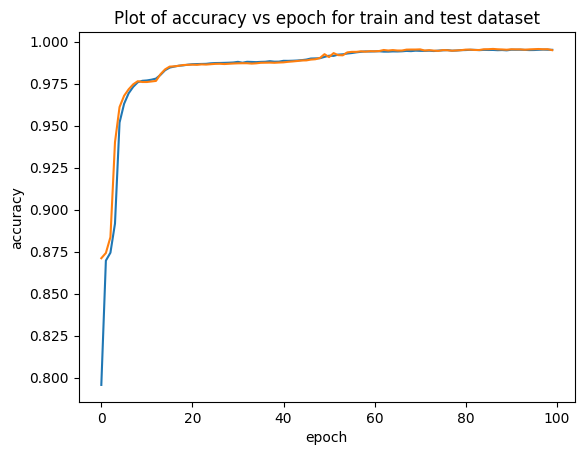

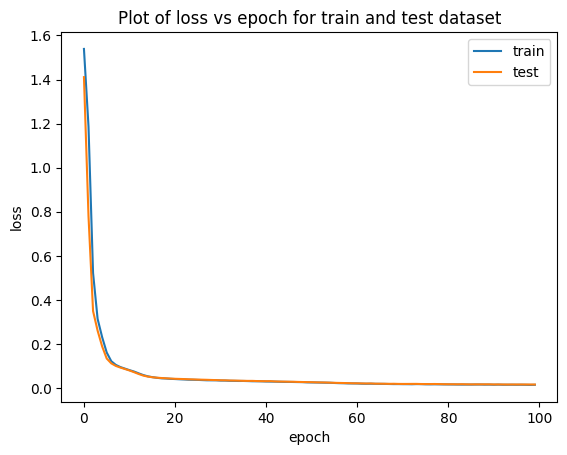

In [ ]:
# Plot of accuracy vs epoch for train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()